# GORMITI_FACE_RECOGNITION

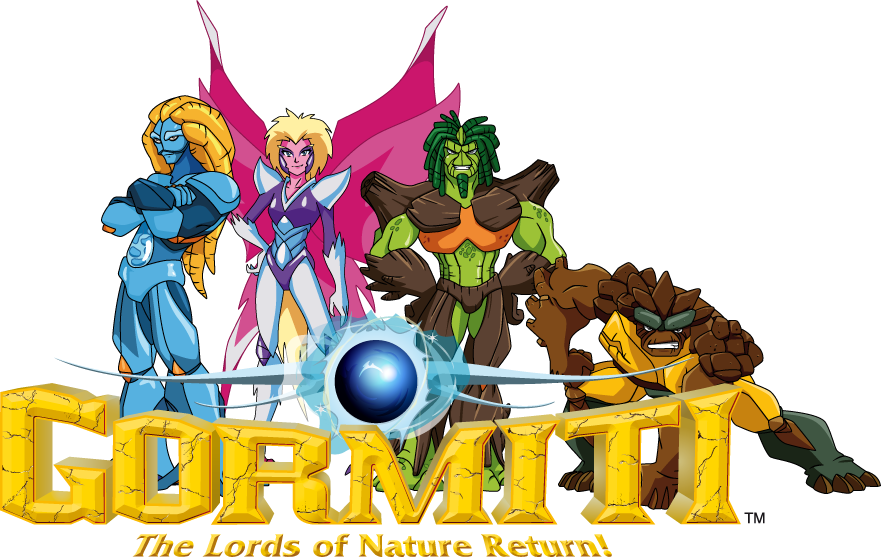

**Source**: *Gormiti: The Lords of Nature Return!*

## Problem Statement

El objetivo de este proyecto es la elaboración de un modelo de reconocimiento facial empleando *Convolutional Neural Networks (CNN)*. El propósito de estas redes neuronales convolucionales será el de identificar y clasificar el rostro de los personajes protagonistas de la serie animada de 2008 *"Gormiti: The Lords of Nature Return!"*. Los datos provenientes de las imágenes se utilizarán como variables de entrada y la etiqueta de clasificación como variable de salida.

## Import Packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from PIL import Image
import pathlib
import seaborn as sns
import os
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Data Collection

In [2]:
# Create the dataset

data_dir = pathlib.Path(r'faces/')
image_count = len(list(data_dir.glob('*/*.png')))
print(f'Hay un total de {image_count} imágenes.')

Hay un total de 100 imágenes.


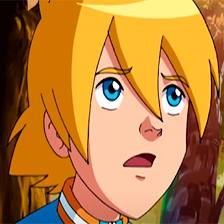

In [3]:
# Example of an image

toby = list(data_dir.glob('toby/*'))
Image.open(str(toby[10]))

## Splitting the data into Training and Validation set

In [4]:
# Define some parameters

batch_size = 32
img_height = 224
img_width = 224

In [5]:
# Create a dataset for training

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='training',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 4 classes.
Using 80 files for training.


In [6]:
# Create a dataset for validation

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset='validation',
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 4 classes.
Using 20 files for validation.


In [7]:
# Class names

class_names = train_ds.class_names
print(class_names)

['jessica', 'lucas', 'nick', 'toby']


## Data Visualization

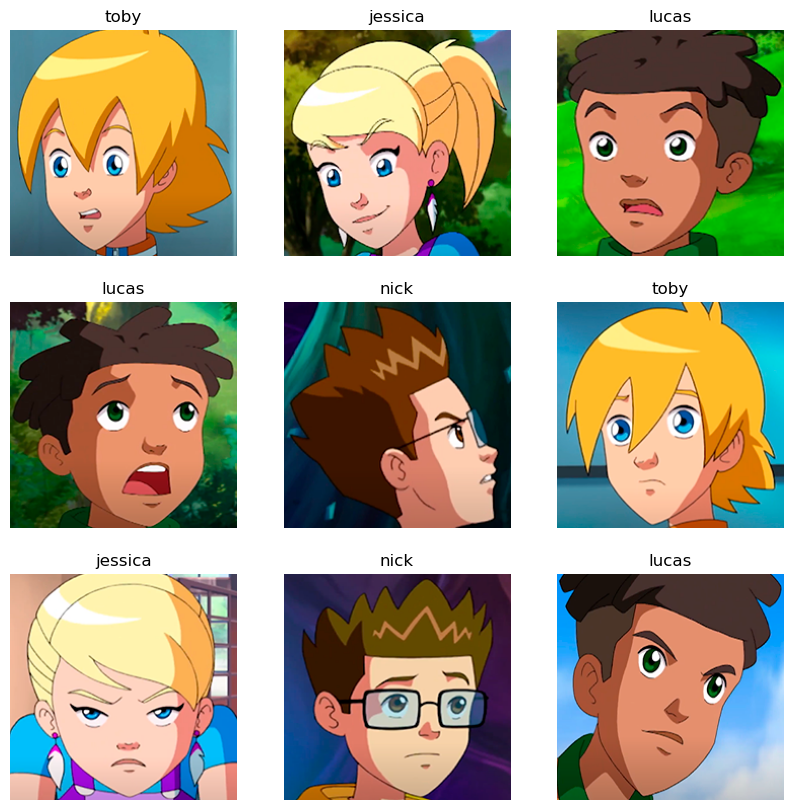

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

Aquí hay nueve imágenes del conjunto de datos de entrenamiento.

## Data Shape

In [17]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


El *image_batch* es un tensor de la forma (32, 224, 224, 3). Este es un lote de 32 imágenes de forma 224x224x3 (la última dimensión se refiere a los canales de color *RGB*). El *label_batch* es un tensor de la forma (32,), estas son las etiquetas correspondientes a las 32 imágenes.

## Standardization/Normalization of Data

Los valores del canal *RGB* se encuentran en el rango [0, 255]. Esto no es ideal para una red neuronal; en general, se busca que sus valores de entrada sean pequeños, así que dichos valores se estandarizarán para que estén en el rango [0, 1].

In [20]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))

# Notice the pixel values are now in '[0,1]'

first_image = image_batch[0]
np.min(first_image), np.max(first_image)

(0.0, 1.0)

## Model training

In [33]:
num_classes = len(class_names)

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(8, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1)

model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

epochs = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[es_callback]
)

Epoch 1/20
3/3 [==============================] - 1s 229ms/step - loss: 3.1991 - accuracy: 0.3375 - val_loss: 11.0745 - val_accuracy: 0.2000
Epoch 2/20
3/3 [==============================] - 1s 216ms/step - loss: 7.7894 - accuracy: 0.3625 - val_loss: 4.4163 - val_accuracy: 0.3500
Epoch 3/20
3/3 [==============================] - 1s 184ms/step - loss: 1.8147 - accuracy: 0.5875 - val_loss: 2.0773 - val_accuracy: 0.4500
Epoch 4/20
3/3 [==============================] - 1s 209ms/step - loss: 2.0977 - accuracy: 0.4750 - val_loss: 1.8212 - val_accuracy: 0.4500
Epoch 5/20
3/3 [==============================] - 1s 240ms/step - loss: 1.1999 - accuracy: 0.6250 - val_loss: 1.1656 - val_accuracy: 0.6000
Epoch 6/20
3/3 [==============================] - 1s 224ms/step - loss: 0.5698 - accuracy: 0.7750 - val_loss: 0.8882 - val_accuracy: 0.5500
Epoch 7/20
3/3 [==============================] - 1s 193ms/step - loss: 0.4891 - accuracy: 0.7875 - val_loss: 1.0741 - val_accuracy: 0.5000
Epoch 8/20
3/3 [===

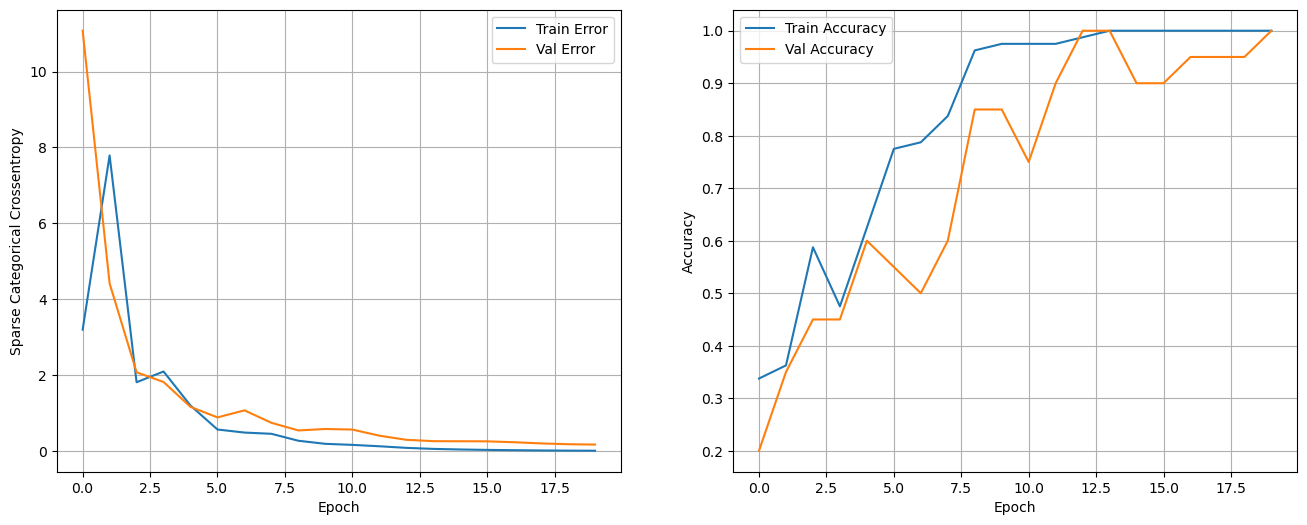

In [34]:
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Sparse Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train Error')
    ax1.plot(hist['epoch'], hist['val_loss'], label='Val Error')
    ax1.grid()
    ax1.legend()
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['accuracy'], label='Train Accuracy')
    ax2.plot(hist['epoch'], hist['val_accuracy'], label='Val Accuracy')
    ax2.grid()
    ax2.legend()
    
    plt.show()
    
show_loss_accuracy_evolution(history)

**Loss**: es la suma de los errores cometidos para cada ejemplo en los conjuntos de entrenamiento o validación. El valor de la pérdida implica lo mal o bien que se comporta un modelo después de cada iteración de optimización.

**Accuracy**: es el cociente entre el número de respuestas correctas dividido entre el número de respuestas totales.

## Predictions for Classification Model with TensorFlow

Test Loss: 0.173
Test Accuracy: 1.000


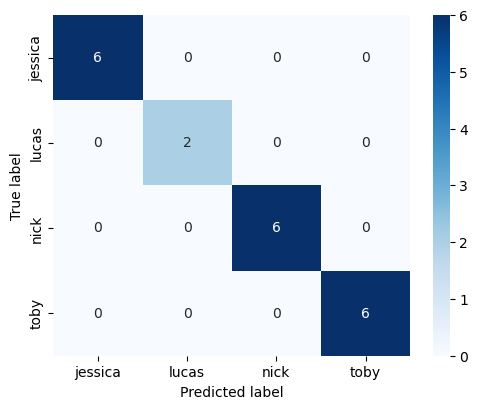

In [57]:
for images, labels in val_ds:
    pred_probs = model.predict(images, verbose=0)
    results = model.evaluate(images, labels, verbose=0)
    preds = pred_probs.argmax(axis=-1)
    predictions = list(preds)
    labels = list(np.array(labels))
    
print('Test Loss: {0:.3f}'.format(results[0]))
print('Test Accuracy: {0:.3f}'.format(results[1]))

# Confusion matrix
con_mat = tf.math.confusion_matrix(
    labels=labels,
    predictions=predictions
).numpy()

con_mat_df = pd.DataFrame(
    con_mat,
    index = class_names,
    columns = class_names)

figure = plt.figure(figsize=(5, 4))
sns.heatmap(con_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

El modelo logra un desempeño excelente, generalizando de forma perfecta en los datos de validación y evitando caer en el sobreajuste.

In [35]:
def show_errors(val_ds, model, class_names, n_images=10):
    n_plots = 0
    for images, labels in val_ds:
        pred_probs = model.predict(images, verbose=0)
        preds = pred_probs.argmax(axis=-1)
        bad_pred_inds = np.where(preds != labels)[0]
        for ind in list(bad_pred_inds):
            n_plots += 1
            real_class = class_names[labels[ind].numpy()]
            pred_class = class_names[preds[ind]]
            prob = pred_probs[ind].max()
            prob_real = pred_probs[ind][[
                i for i, c in enumerate(class_names) if c == real_class
            ][0]]
            plt.imshow(images[ind].numpy().astype('uint8'))
            plt.title(
                'Predicted: {0}, prob: {1:.2f} \n Real: {2}, prob {3:.2f}'
                .format(pred_class, prob, real_class, prob_real))
            plt.show()
            
            if n_plots == n_images:
                return
        return

show_errors(val_ds, model, class_names, n_images=10)

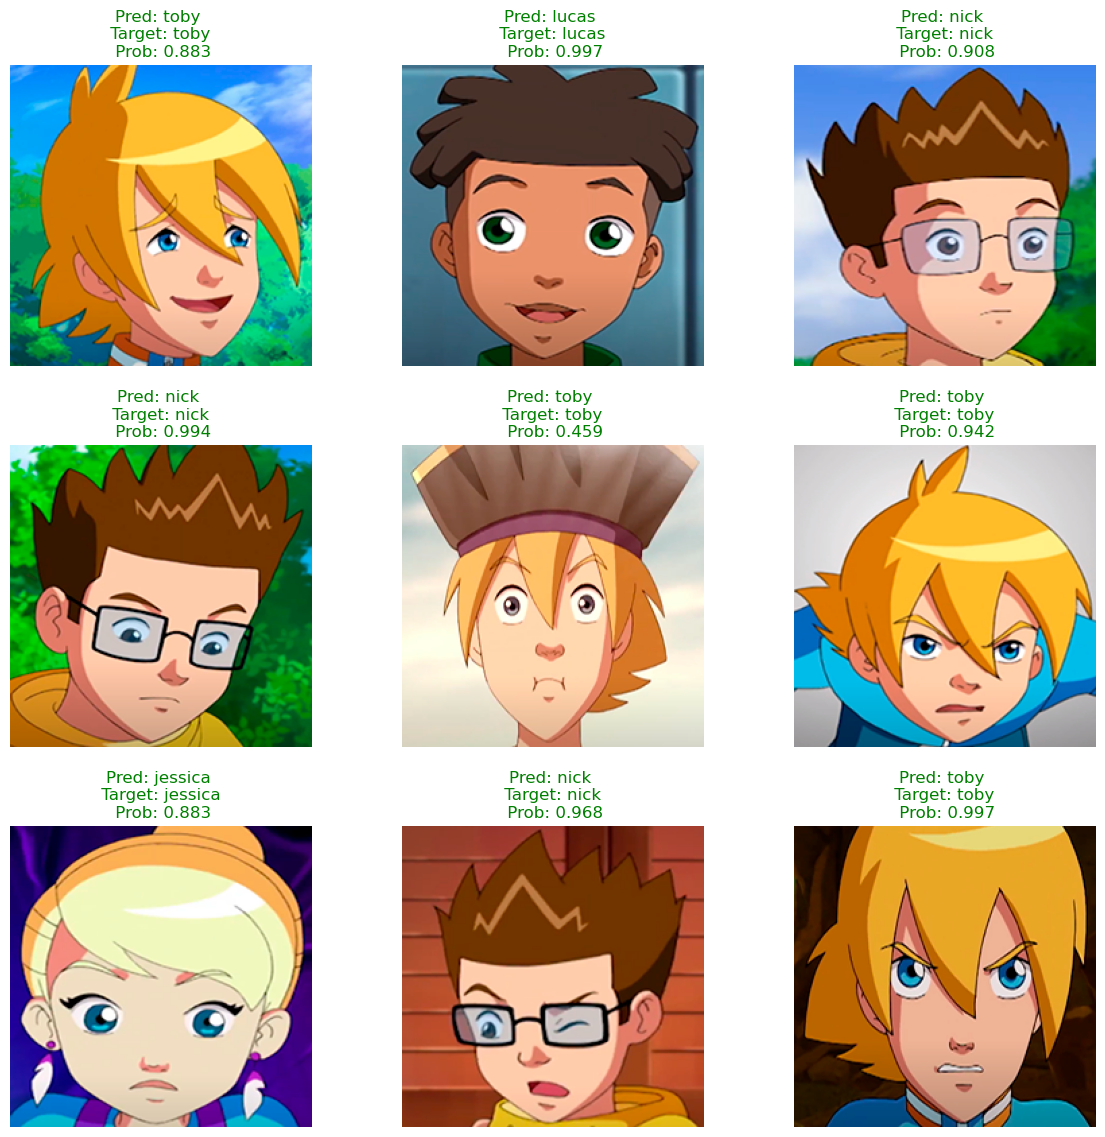

In [56]:
for images, labels in val_ds:
    predictions = model.predict(images, verbose=0)
    predicted_classes = np.argmax(predictions, axis=-1)
    
    L = 3
    W = 3
    
    fig, axes = plt.subplots(L, W, figsize=(14, 14))
    axes = axes.ravel()
    
    for i in np.arange(0, L * W):
        ind = np.random.randint(len(labels))
        axes[i].imshow(images[ind].numpy().astype('uint8'))
        prob_pred = np.max(predictions[ind, :])
        class_pred = class_names[labels[ind].numpy()]
        original_class = class_names[predicted_classes[ind]]
        if class_pred == original_class:
            color = 'green'
        else:
            color = 'red'
        
        title = 'Pred: {0} \n Target: {1} \n Prob: {2:.3f}'.format(
        class_pred, original_class, prob_pred)
        axes[i].set_title(title, color=color)
        axes[i].axis('off')
        
    plt.subplots_adjust(wspace=0.3)    